In [1]:
import baltic as bt
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from datetime import datetime as dt
from datetime import timedelta
import time
#import pymc3
import math
import arviz as az
import re
#from hpd import hpd
import scipy.stats as stats
from io import StringIO
import altair as alt
from altair import datum
from sklearn.linear_model import LinearRegression
import seaborn as sns
import scipy as sp
from scipy.stats import pearsonr
from scipy.interpolate import splrep, BSpline
from matplotlib import pyplot 


alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')


### Load Log files

In [2]:
from datetime import date
current_date = str(date.today())

In [4]:
log_file_path = "../mascot_glm/results/main/combined_exp_glm.log"


In [5]:
domain = ['CentralEurope', 'NorthAmerica', 'SouthAmerica' ,"SouthernEurope", "WesternEurope"]
range_ = ['#EEC060', '#2664A5', '#A76BB1', "#EEA160", "#356D4C"]

## we can then estimate the transmission rates via the change in Ne's over time plus the uninfectious rate

In [6]:
def read_in_Ne_changes_mascot(log_file_path):
    
    Ne_skyline_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
            
            # use the first line to find the migration rate columns
                if "posterior" in line:
                    all_cols = line.split("\t")
                    Ne_column_indices = []   # list to store column indices
                    Nes_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "Ne." in col:
                            Ne_column_indices.append(i)

                    # make an empty dictionary to store Nes and generate dictionary to convert index to name
                    for n in Ne_column_indices:
                        name = line.split("\t")[n]
                        deme = name.split(".")[1]# the syntax here is "NeLog.state01" where 0 is deme and 1 is interval 1
                        interval = name.split(".")[2]
                       
                        Nes_key[n] = name
                        Ne_skyline_dict[name] = []


                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    Ne_skyline_dict["sample"].append(sample)

                    for index in Ne_column_indices:
                        name = Nes_key[index]
                        Ne_skyline_dict[name].append(line.split("\t")[index])
                    
                
    return(Ne_skyline_dict)

In [7]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()
    
    for i in input_df.columns.tolist():
        if "Ne" in i:
            deme = i.split(".")[1]
            interval = i.split(".")[2]
            next_interval = int(interval)+7
            local_series = input_df[i].astype('float').to_numpy()
            mean_log = local_series.mean()
            mean_linear = 10**mean_log
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            lower_hpd_linear_95 = 10**lower_hpd_log_95
            upper_hpd_log_95 = hpd_95[1]
            upper_hpd_linear_95 = 10**upper_hpd_log_95
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            lower_hpd_linear_50 = 10**lower_hpd_log_50
            upper_hpd_log_50 = hpd_50[1]
            upper_hpd_linear_50 = 10**upper_hpd_log_50
            
            try:
                next_local_series = input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float').to_numpy()
                diff_series = np.subtract(local_series, next_local_series)
                diff_mean_log = diff_series.mean()
                diff_hpd_95 = az.hdi(diff_series, 0.95)
                diff_lower_hpd_log_95 = diff_hpd_95[0]
                diff_lower_hpd_linear_95 = math.exp(diff_lower_hpd_log_95)
                diff_upper_hpd_log_95 = diff_hpd_95[1]
                diff_upper_hpd_linear_95 = math.exp(diff_upper_hpd_log_95)
                diff_hpd_50 = az.hdi(diff_series, 0.50)
                diff_lower_hpd_log_50 = diff_hpd_50[0]
                diff_lower_hpd_linear_50 = math.exp(diff_lower_hpd_log_50)
                diff_upper_hpd_log_50 = diff_hpd_50[1]
                diff_upper_hpd_linear_50 = math.exp(diff_upper_hpd_log_50)
            except KeyError:
                pass   
            
            try:
                local_df = pd.DataFrame.from_dict({"deme":deme, "interval":interval, "mean_Ne_log":mean_log,"mean_Ne_linear":mean_linear, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50,
                                                   "upper_hpd_linear":upper_hpd_linear_95,"lower_hpd_linear":lower_hpd_linear_95,
                                                   "diff_mean_Ne_log":diff_mean_log, 
                                                   "diff_upper_hpd_log_95":diff_upper_hpd_log_95,"diff_lower_hpd_log_95":diff_lower_hpd_log_95, 
                                                   "diff_upper_hpd_log_50":diff_upper_hpd_log_50,"diff_lower_hpd_log_50":diff_lower_hpd_log_50,
                                                   "diff_upper_hpd_linear":diff_upper_hpd_linear_95,"diff_lower_hpd_linear":diff_lower_hpd_linear_95,
                                                   "diff_upper_hpd_linear_50":diff_upper_hpd_linear_50,"diff_lower_hpd_linear_50":diff_lower_hpd_linear_50})
                new_df = new_df.append(local_df)
            except:
                pass
            
    return(new_df)

In [8]:
Ne_skyline = read_in_Ne_changes_mascot(log_file_path)

In [9]:
Ne_df = pd.DataFrame.from_dict(Ne_skyline)
print(len(Ne_df))
burnin_percent = 0.3

rows_to_remove = int(len(Ne_df)* burnin_percent)
Ne_df = Ne_df.iloc[rows_to_remove:]

print(len(Ne_df))
Ne_df = Ne_df.reset_index()
Ne_df

28124
19687


,index,sample,Ne.CentralEurope.0,Ne.CentralEurope.1,Ne.CentralEurope.2,Ne.CentralEurope.3,Ne.CentralEurope.4,Ne.CentralEurope.5,Ne.CentralEurope.6,Ne.CentralEurope.7,...,Ne.WesternEurope.34,Ne.WesternEurope.35,Ne.WesternEurope.36,Ne.WesternEurope.37,Ne.WesternEurope.38,Ne.WesternEurope.39,Ne.WesternEurope.40,Ne.WesternEurope.41,Ne.WesternEurope.42,Ne.WesternEurope.43
0,8437,42185000,9.319618186933987E-4,0.0013018078890170127,0.0017871686495254983,0.0025429238575860286,0.003500380551469947,0.009430594266804199,0.012957760666712163,0.01776631205296723,...,0.6112063352521832,0.11606685361111267,0.11606685361111267,0.11606685361111267,0.11606685361111267,0.11606685361111267,0.11606685361111267,0.11606685361111267,0.11606685361111267,0.11606685361111267
1,8438,42190000,0.0011801855716049982,0.0016485384452481341,0.0022631728166201564,0.0032202199555993586,0.004432690845386066,0.007984036156306062,0.010970170780430461,0.01504113884894923,...,0.5232117587845859,0.0993568605426958,0.0993568605426958,0.0993568605426958,0.0993568605426958,0.0993568605426958,0.0993568605426958,0.0993568605426958,0.0993568605426958,0.0993568605426958
2,8439,42195000,0.016152774387212396,0.02048936907052437,0.02567154036502838,0.03299433512228065,0.0414181268521564,0.0522259316137406,0.06547483596460138,0.08196066559286273,...,1.3717572229709274,0.18248932787952438,0.18248932787952438,0.18248932787952438,0.18248932787952438,0.18248932787952438,0.18248932787952438,0.18248932787952438,0.18248932787952438,0.18248932787952438
3,8440,42200000,6.124678551885556E-4,8.578913333318219E-4,0.001180834016450479,0.0016850903187198066,0.00232569438667561,0.004983035501644297,0.006864768395787495,0.009436840163881762,...,0.5228394492303565,0.10340465951884927,0.10340465951884927,0.10340465951884927,0.10340465951884927,0.10340465951884927,0.10340465951884927,0.10340465951884927,0.10340465951884927,0.10340465951884927
4,8441,42205000,0.0011939505750727122,0.0016723814027204541,0.0023019288948191875,0.003284930854804749,0.0045337304266521265,0.004469938700548457,0.006157911961997267,0.008465140785271531,...,0.484130034006536,0.10450369736755237,0.10450369736755237,0.10450369736755237,0.10450369736755237,0.10450369736755237,0.10450369736755237,0.10450369736755237,0.10450369736755237,0.10450369736755237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19682,28119,140595000,0.003292611207550264,0.004391534139222483,0.005770365131054429,0.007819683474598547,0.010298609762564316,0.017643716305120353,0.02320052821990675,0.030451580568532213,...,0.7073926540423983,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147,0.06903593085698147
19683,28120,140600000,0.0010018342842830076,0.0013706304010637194,0.0018449426070125186,0.0025681938691472683,0.0034656224547089482,0.017774870467125867,0.02394517722460166,0.03219315388480236,...,0.5617846806840007,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374,0.06764261384946374
19684,28121,140605000,0.001321059162915087,0.0018073686224374694,0.00243281586015061,0.003386524194874665,0.004569909785303587,0.02102400118716855,0.028322199890460774,0.038077853042280146,...,0.6851209389283835,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386,0.06717052928691386
19685,28122,140610000,7.86972341544367E-4,0.0010766732912209894,0.0014492604477942372,0.002017397063017435,0.0027223554442868227,0.009589688362034603,0.01291861945111257,0.017368470488561456,...,0.67784730707066,0.06356257655870785,0.06356257655870785,0.06356257655870785,0.06356257655870785,0.06356257655870785,0.06356257655870785,0.06356257655870785,0.06356257655870785,0.06356257655870785


## calculating transmission rate

In [15]:
def generate_summary_diff_df(input_df):
    
    
    new_df = pd.DataFrame()
   
    for i in input_df.columns.tolist():
        if "Ne" in i:
            deme = i.split(".")[1]
            interval = i.split(".")[2]
            next_interval = int(interval)+3 #averaging over three weeks to reduce noise
            local_series = input_df[i].astype('float').to_numpy()
           
            try:
                new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
            
            
            except KeyError:
                pass 
            
            
    return(new_df)

In [16]:
ne_diff_summary = generate_summary_diff_df(Ne_df)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("floa

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("floa

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("floa

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("floa

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("float")) - np.log(input_df["Ne"+"."+ str(deme) +"." + str(next_interval)].astype('float')))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/3730868639.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["Ne"+"."+ str(deme) +".diff." + str(interval)] = (52/3)*(np.log(input_df[i].astype("floa

In [17]:
ne_diff_summary

,Ne.CentralEurope.diff.0,Ne.CentralEurope.diff.1,Ne.CentralEurope.diff.2,Ne.CentralEurope.diff.3,Ne.CentralEurope.diff.4,Ne.CentralEurope.diff.5,Ne.CentralEurope.diff.6,Ne.CentralEurope.diff.7,Ne.CentralEurope.diff.8,Ne.CentralEurope.diff.9,...,Ne.WesternEurope.diff.31,Ne.WesternEurope.diff.32,Ne.WesternEurope.diff.33,Ne.WesternEurope.diff.34,Ne.WesternEurope.diff.35,Ne.WesternEurope.diff.36,Ne.WesternEurope.diff.37,Ne.WesternEurope.diff.38,Ne.WesternEurope.diff.39,Ne.WesternEurope.diff.40
0,-17.398818,-17.144707,-28.830993,-28.225259,-28.156828,-16.173722,-13.860997,-13.480113,-13.462901,-15.204734,...,38.164256,59.909605,52.373814,28.795316,0.0,0.0,0.0,0.0,0.0,0.0
1,-17.398818,-17.144707,-21.851723,-21.245990,-21.177559,-16.173722,-6.136462,-5.755577,-5.738365,-15.204734,...,38.164256,59.909605,52.373814,28.795316,0.0,0.0,0.0,0.0,0.0,0.0
2,-12.380230,-12.199416,-12.310067,-11.879053,-11.830361,-11.508506,9.721377,9.992398,10.004645,-10.819017,...,27.155999,57.103593,51.741457,34.964040,0.0,0.0,0.0,0.0,0.0,0.0
3,-17.542685,-17.286473,-24.956850,-24.346108,-24.277111,-16.307459,-22.212514,-21.828480,-21.811126,-15.330458,...,38.479828,59.462388,51.864286,28.090823,0.0,0.0,0.0,0.0,0.0,0.0
4,-17.542685,-17.286473,-11.502873,-10.892131,-10.823134,-16.307459,-26.311477,-25.927443,-25.910089,-15.330458,...,38.479828,57.945837,50.347735,26.574272,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19682,-14.992695,-14.773725,-19.372502,-18.850537,-18.791569,-13.937020,-8.358182,-8.029971,-8.015139,-13.102035,...,32.886431,67.145372,60.651724,40.333952,0.0,0.0,0.0,0.0,0.0,0.0
19683,-16.317085,-16.078772,-39.265850,-38.697777,-38.633600,-15.168156,-0.309612,0.047592,0.063733,-14.259412,...,35.791477,65.872421,58.805151,36.692595,0.0,0.0,0.0,0.0,0.0,0.0
19684,-16.317085,-16.078772,-37.381332,-36.813259,-36.749082,-15.168156,13.340645,13.697850,13.713991,-14.259412,...,35.791477,69.434079,62.366809,40.254253,0.0,0.0,0.0,0.0,0.0,0.0
19685,-16.317085,-16.078772,-32.753673,-32.185600,-32.121423,-15.168156,-0.407671,-0.050466,-0.034325,-14.259412,...,35.791477,70.206043,63.138774,41.026218,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
uninfectious_rate = 365/4.5

#taken from https://www.medrxiv.org/content/10.1101/2022.08.17.22278897v1.full.pdf


In [19]:
incubation_period = 365/8

In [20]:
seir_growth_rate = ((ne_diff_summary*2 + uninfectious_rate + incubation_period)**2 - (incubation_period- uninfectious_rate)**2)/(4*incubation_period)



seir_growth_rate



,Ne.CentralEurope.diff.0,Ne.CentralEurope.diff.1,Ne.CentralEurope.diff.2,Ne.CentralEurope.diff.3,Ne.CentralEurope.diff.4,Ne.CentralEurope.diff.5,Ne.CentralEurope.diff.6,Ne.CentralEurope.diff.7,Ne.CentralEurope.diff.8,Ne.CentralEurope.diff.9,...,Ne.WesternEurope.diff.31,Ne.WesternEurope.diff.32,Ne.WesternEurope.diff.33,Ne.WesternEurope.diff.34,Ne.WesternEurope.diff.35,Ne.WesternEurope.diff.36,Ne.WesternEurope.diff.37,Ne.WesternEurope.diff.38,Ne.WesternEurope.diff.39,Ne.WesternEurope.diff.40
0,39.415995,39.929467,19.243675,20.168770,20.274291,41.917569,46.819349,47.649114,47.686760,43.942785,...,219.046451,326.193218,286.714834,179.271696,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
1,39.415995,39.929467,30.877585,31.987998,32.114455,41.917569,64.890724,65.849461,65.892935,43.942785,...,219.046451,326.193218,286.714834,179.271696,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
2,50.080927,50.485779,50.237857,51.206604,51.316558,52.045958,110.186281,111.056220,111.095608,53.623791,...,172.707690,311.202237,283.515262,205.027616,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
3,39.126544,39.642658,25.437911,26.474441,26.592569,41.641287,30.223837,30.919897,30.951504,43.677693,...,220.453157,323.780865,284.135374,176.436394,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
4,39.126544,39.642658,52.058765,53.455489,53.614308,41.641287,23.197238,23.824294,23.852783,43.677693,...,220.453157,315.665635,276.525258,170.406713,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19682,44.391442,44.856832,35.524224,36.536843,36.651992,46.654493,59.425100,60.218907,60.254889,48.479053,...,196.166798,366.442495,330.215662,228.806365,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
19683,41.621432,42.114198,5.832335,6.439597,6.509090,44.020039,80.253178,81.243360,81.288237,45.958198,...,208.609246,359.195280,320.251536,212.543951,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
19684,41.621432,42.114198,7.901233,8.555424,8.630218,44.020039,122.069234,123.273155,123.327691,45.958198,...,208.609246,379.651308,339.604169,228.444206,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111
19685,41.621432,42.114198,13.642178,14.411606,14.499419,44.020039,79.982335,80.970982,81.015790,45.958198,...,208.609246,384.158331,343.872039,231.963798,81.111111,81.111111,81.111111,81.111111,81.111111,81.111111


In [21]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "Ne" in i:
            deme = i.split(".")[1]
            interval = i.split(".")[3]
            local_series = input_df[i].astype('float').to_numpy()
            mean_percent = local_series.mean()
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            upper_hpd_log_95 = hpd_95[1]
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            upper_hpd_log_50 = hpd_50[1]
            

            
            
            try:
                local_df = pd.DataFrame.from_dict({"deme": deme, "interval":interval, "mean_percent":mean_percent, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50})
                new_df = new_df.append(local_df)
            except:
                pass
            
    return(new_df)

In [22]:
#plot just checking to make sure the changes in Ne look okay
test = generate_summary_df(ne_diff_summary)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_6924/2825524539.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


In [23]:
test

,deme,interval,mean_percent,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50
0,CentralEurope,0,-16.388540,-11.659166,-21.248318,-14.772163,-18.011410
0,CentralEurope,1,-16.149184,-11.488883,-20.937985,-14.556414,-17.748352
0,CentralEurope,2,-22.823909,17.769786,-65.374965,-10.346758,-34.043944
0,CentralEurope,3,-22.253348,17.325918,-65.808242,-9.828469,-33.514964
0,CentralEurope,4,-22.188890,17.382171,-65.733297,-9.765649,-33.446606
...,...,...,...,...,...,...,...
0,WesternEurope,36,0.000000,0.000000,0.000000,0.000000,0.000000
0,WesternEurope,37,0.000000,0.000000,0.000000,0.000000,0.000000
0,WesternEurope,38,0.000000,0.000000,0.000000,0.000000,0.000000
0,WesternEurope,39,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
test['days'] = test.interval.astype(int) *7
test['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - test.days.map(timedelta)
test.date = test.date.astype(str)

In [25]:
test

,deme,interval,mean_percent,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,days,date
0,CentralEurope,0,-16.388540,-11.659166,-21.248318,-14.772163,-18.011410,0,2023-01-03
0,CentralEurope,1,-16.149184,-11.488883,-20.937985,-14.556414,-17.748352,7,2022-12-27
0,CentralEurope,2,-22.823909,17.769786,-65.374965,-10.346758,-34.043944,14,2022-12-20
0,CentralEurope,3,-22.253348,17.325918,-65.808242,-9.828469,-33.514964,21,2022-12-13
0,CentralEurope,4,-22.188890,17.382171,-65.733297,-9.765649,-33.446606,28,2022-12-06
...,...,...,...,...,...,...,...,...,...
0,WesternEurope,36,0.000000,0.000000,0.000000,0.000000,0.000000,252,2022-04-26
0,WesternEurope,37,0.000000,0.000000,0.000000,0.000000,0.000000,259,2022-04-19
0,WesternEurope,38,0.000000,0.000000,0.000000,0.000000,0.000000,266,2022-04-12
0,WesternEurope,39,0.000000,0.000000,0.000000,0.000000,0.000000,273,2022-04-05


In [26]:
test = test[test.date >"2022-05-20"] ; test

,deme,interval,mean_percent,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,days,date
0,CentralEurope,0,-16.388540,-11.659166,-21.248318,-14.772163,-18.011410,0,2023-01-03
0,CentralEurope,1,-16.149184,-11.488883,-20.937985,-14.556414,-17.748352,7,2022-12-27
0,CentralEurope,2,-22.823909,17.769786,-65.374965,-10.346758,-34.043944,14,2022-12-20
0,CentralEurope,3,-22.253348,17.325918,-65.808242,-9.828469,-33.514964,21,2022-12-13
0,CentralEurope,4,-22.188890,17.382171,-65.733297,-9.765649,-33.446606,28,2022-12-06
...,...,...,...,...,...,...,...,...,...
0,WesternEurope,28,5.856039,20.485326,-8.722107,10.687906,0.626972,196,2022-06-21
0,WesternEurope,29,8.978299,23.614313,-5.531921,13.833338,3.805845,203,2022-06-14
0,WesternEurope,30,11.436462,26.304021,-2.929133,16.201835,6.160738,210,2022-06-07
0,WesternEurope,31,35.948214,46.608123,25.574347,39.507974,32.402696,217,2022-05-31


In [27]:
test[(test.date >"2022-05-30") &  (test.date <"2022-06-30")]

,deme,interval,mean_percent,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,days,date
0,CentralEurope,27,5.078171,6.584027,3.612722,5.581035,4.577319,189,2022-06-28
0,CentralEurope,28,-0.082462,15.372572,-14.164039,4.743209,-5.448666,196,2022-06-21
0,CentralEurope,29,-1.702048,13.848507,-15.807772,3.094976,-7.192469,203,2022-06-14
0,CentralEurope,30,-3.725086,11.687242,-18.270585,1.286235,-9.151951,210,2022-06-07
0,CentralEurope,31,0.000000,0.000000,0.000000,0.000000,0.000000,217,2022-05-31
0,NorthAmerica,27,21.580658,27.980081,15.352952,23.717675,19.452190,189,2022-06-28
0,NorthAmerica,28,8.289963,22.723348,-6.454682,13.027844,3.004128,196,2022-06-21
0,NorthAmerica,29,3.432468,18.412430,-10.849700,7.708207,-2.375961,203,2022-06-14
0,NorthAmerica,30,-8.003989,7.700989,-22.772266,-2.851850,-13.594937,210,2022-06-07
0,NorthAmerica,31,0.000000,0.000000,0.000000,0.000000,0.000000,217,2022-05-31


In [28]:
line = alt.Chart(test).mark_area().encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('lower_hpd_log_50',axis=alt.Axis(title="transmission rate"), scale = alt.Scale(zero= False)),
    alt.Y2('upper_hpd_log_50'),
    color=alt.Color('deme:N')
).properties(
    width=850,
    height=300
)

band = alt.Chart(test).mark_area(
    opacity=0.3
).encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('lower_hpd_log_95'),
    alt.Y2('upper_hpd_log_95'),
    color=alt.Color('deme:N')
).properties(
    width=850,
    height=300
)

band + line

alt.LayerChart(...)

## calculating backward migration rates

In [21]:
def read_in_forward_migration_rates_mascot(log_file_path):
    
    mig_rates_dict = {"sample":[]}
    
    with open(log_file_path, "r") as infile:
        line_number = 0
        for line in infile:
            #print(line_number)
            line_number += 1
            if not line.startswith("#"):  # log combiner will sometimes put the entire xml at the start of the log file
                # use the first line to find the migration rate columns
                
            # use the first line to find the migration rate columns
                if "posterior" in line:
                    all_cols = line.split("\t")
                    mig_column_indices = []   # list to store column indices
                    mig_key = {}   # dictionary to store the column index to map to column name

                    for i in range(len(all_cols)):
                        col = all_cols[i]
                        if "mig." in col:
                            mig_column_indices.append(i)

                    # make an empty dictionary to store Nes and generate dictionary to convert index to name
                    for n in mig_column_indices:
                        name = line.split("\t")[n]
                        deme = name.split(".")[1]# the syntax here is "NeLog.state01" where 0 is deme and 1 is interval 1
                        #interval = name.split(".")[2]
                       
                        mig_key[n] = name
                        mig_rates_dict[name] = []


                # read in actual parameter estimates and store in dictionary
                else:
                    sample = line.split("\t")[0]
                    mig_rates_dict["sample"].append(sample)

                    for index in mig_column_indices:
                        name = mig_key[index]
                        mig_rates_dict[name].append(line.split("\t")[index])
                    
                
                
                
    return(mig_rates_dict)

In [22]:
migration_rates_f = read_in_forward_migration_rates_mascot(log_file_path)

In [23]:
mig_df_f = pd.DataFrame.from_dict(migration_rates_f)


In [24]:
burnin_percent = 0.3
print(len(mig_df_f))
rows_to_remove = int(len(mig_df_f)* burnin_percent)
mig_df_f = mig_df_f.iloc[rows_to_remove:]

print(len(mig_df_f))
mig_df_f = mig_df_f.reset_index()
mig_df_f.head()

28124
19687


,index,sample,mig.CentralEurope_to_NorthAmerica,mig.CentralEurope_to_SouthAmerica,mig.CentralEurope_to_SouthernEurope,mig.CentralEurope_to_WesternEurope,mig.NorthAmerica_to_CentralEurope,mig.NorthAmerica_to_SouthAmerica,mig.NorthAmerica_to_SouthernEurope,mig.NorthAmerica_to_WesternEurope,...,mig.SouthAmerica_to_SouthernEurope,mig.SouthAmerica_to_WesternEurope,mig.SouthernEurope_to_CentralEurope,mig.SouthernEurope_to_NorthAmerica,mig.SouthernEurope_to_SouthAmerica,mig.SouthernEurope_to_WesternEurope,mig.WesternEurope_to_CentralEurope,mig.WesternEurope_to_NorthAmerica,mig.WesternEurope_to_SouthAmerica,mig.WesternEurope_to_SouthernEurope
0,8437,42185000,0.03799477377841695,0.011429975429968991,0.08890506904716153,0.16231623390749675,0.04113699402445201,0.3646711164943031,0.3864467102073515,0.6286009525529325,...,0.23790367522237907,0.15255193190058214,0.08819694553176476,0.3715151396638434,0.22613031266114,0.9881451537149847,0.16531081463522956,0.6324290536515912,0.16209583275633246,0.9843059872893192
1,8438,42190000,0.06020608198654256,0.021057386079466795,0.13057011647443498,0.2186387830854512,0.06486843624190401,0.4333053400373227,0.46866833225907545,0.7350066364076173,...,0.3056114594400864,0.21371167714133107,0.12662115409599814,0.45904626850911723,0.29173413064177056,1.0641409290533888,0.21852729503327428,0.7249717171835462,0.2157045813924031,1.0816971873552756
2,8439,42195000,0.056967865393504964,0.020994426106134095,0.1204641893073056,0.1945237536166209,0.06190612678520576,0.3814655666955194,0.40484340399769264,0.6332719682047676,...,0.26607835917201517,0.18825962831646553,0.12011377479032245,0.4012312384421174,0.2543396787459667,0.9168529573732417,0.19837144582578545,0.6188568057261528,0.1958682317049028,0.9226474590707352
3,8440,42200000,0.07102202496716153,0.026893950384956705,0.14530219987355705,0.23819501683222827,0.07618785860169124,0.4589484975626911,0.4802909981132437,0.726218209164135,...,0.32204963149021376,0.22392239018850654,0.14435075850555493,0.4731879731447152,0.3055295059154437,1.0384314749217192,0.2369588932126055,0.7125932700666591,0.2341902242640458,1.0477803703756141
4,8441,42205000,0.045396787752666,0.016067999306612565,0.09749967640376837,0.165218724668723,0.04905783761582666,0.3404433740041551,0.3543897658114133,0.5527755905769502,...,0.23061770135907866,0.1591387691936777,0.09728829174914837,0.3486927379800219,0.21674886943448826,0.8276026791480087,0.1658103342858395,0.5419413381582535,0.16374861714718852,0.8253715294536541


In [27]:
def calc_backwards_mig_rates(mig_df_f, targetName):    
    mig_rates = {}
    target = targetName
    target_columns = []
    ne_interval= 0
    mig_list = []

    for name in mig_df_f.columns:
        try:
            if target in name.split("_")[2]:
                target_columns.append(name)
        except:
            pass

    for name in Ne_df.columns:
        if target in name:
            ne_interval+=1

    for interval in range(0, ne_interval,1):
        mig_rates[str(interval)+ "." + "bmr" + "." +  str(target)] = []
        for index_1, row_1 in mig_df_f.iterrows():
            mig_list = []
            for direction in target_columns:
                other_loc = direction.split("_")[0].split(".")[1]
                mig_rate_b = pd.to_numeric(row_1[direction]) * ((pd.to_numeric(Ne_df.loc[index_1,"Ne."+ str(other_loc) + "." + str(interval)]))/(pd.to_numeric(Ne_df.loc[index_1, "Ne."+ str(target) + "." + str(interval)])))
                mig_list.append(mig_rate_b)
            combined_mig = np.sum(np.array(mig_list))
            mig_rates[str(interval)+ "." + "bmr" + "." + str(target)].append(combined_mig)

    return(mig_rates) 


In [28]:
#### if the forward migration rate is 
#### from a -> b then the backwards migration rate is from b - > a and interpreted as the rate
#### at which a lineage in b has originated from a
#### so our target is not necessarily location a but rather location b.

unique_column= []
unique_target = []
for name in mig_df_f.columns:
    try:
        if name.split("_")[2] not in unique_target:
            unique_column.append(name)
            unique_target.append(name.split("_")[2])
    except:
        pass

In [30]:
mig_rates = []
for target in unique_target:
        mig_rates.append(calc_backwards_mig_rates(mig_df_f, target))

In [31]:
mr_b_df = pd.DataFrame()
for x in mig_rates:
    x_df = pd.DataFrame(x)
    mr_b_df = pd.concat([mr_b_df, x_df], axis=1)


In [32]:
mr_b_df

,0.bmr.NorthAmerica,1.bmr.NorthAmerica,2.bmr.NorthAmerica,3.bmr.NorthAmerica,4.bmr.NorthAmerica,5.bmr.NorthAmerica,6.bmr.NorthAmerica,7.bmr.NorthAmerica,8.bmr.NorthAmerica,9.bmr.NorthAmerica,...,34.bmr.CentralEurope,35.bmr.CentralEurope,36.bmr.CentralEurope,37.bmr.CentralEurope,38.bmr.CentralEurope,39.bmr.CentralEurope,40.bmr.CentralEurope,41.bmr.CentralEurope,42.bmr.CentralEurope,43.bmr.CentralEurope
0,0.494233,0.499935,0.503529,0.507411,0.513071,0.516290,0.517017,0.513734,0.505403,0.494049,...,0.670835,0.670835,0.670835,0.670835,0.670835,0.670835,0.670835,0.670835,0.670835,0.670835
1,0.620687,0.628199,0.632984,0.637985,0.644940,0.648472,0.648551,0.643311,0.631554,0.615936,...,0.949732,0.949732,0.949732,0.949732,0.949732,0.949732,0.949732,0.949732,0.949732,0.949732
2,0.652127,0.661414,0.670220,0.679500,0.690125,0.698140,0.703251,0.703896,0.698912,0.690092,...,0.650040,0.650040,0.650040,0.650040,0.650040,0.650040,0.650040,0.650040,0.650040,0.650040
3,0.629252,0.637256,0.642358,0.647522,0.654366,0.657305,0.656338,0.649615,0.636036,0.618457,...,1.063065,1.063065,1.063065,1.063065,1.063065,1.063065,1.063065,1.063065,1.063065,1.063065
4,0.460966,0.466835,0.470713,0.474765,0.480218,0.483007,0.483097,0.479086,0.470099,0.458173,...,0.715963,0.715963,0.715963,0.715963,0.715963,0.715963,0.715963,0.715963,0.715963,0.715963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19682,0.623703,0.631783,0.638306,0.645239,0.654003,0.660043,0.663189,0.661708,0.654333,0.643171,...,0.685442,0.685442,0.685442,0.685442,0.685442,0.685442,0.685442,0.685442,0.685442,0.685442
19683,0.537630,0.544472,0.549867,0.555921,0.564120,0.570208,0.573986,0.573746,0.568220,0.559320,...,0.480398,0.480398,0.480398,0.480398,0.480398,0.480398,0.480398,0.480398,0.480398,0.480398
19684,0.469049,0.475433,0.480657,0.486477,0.494088,0.499736,0.503224,0.503052,0.498131,0.490175,...,0.442774,0.442774,0.442774,0.442774,0.442774,0.442774,0.442774,0.442774,0.442774,0.442774
19685,0.554602,0.561815,0.567446,0.573646,0.581873,0.587698,0.590942,0.589881,0.583275,0.573163,...,0.567731,0.567731,0.567731,0.567731,0.567731,0.567731,0.567731,0.567731,0.567731,0.567731


In [33]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    count = 0
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        #if count %7 == 0:
        deme = i.split(".")[2]
        interval = i.split(".")[0]
        local_series = input_df[i].astype('float').to_numpy()
        mean_percent = local_series.mean()
        hpd_95 = az.hdi(local_series, 0.95)
        lower_hpd_log_95 = hpd_95[0]
        upper_hpd_log_95 = hpd_95[1]
        hpd_50 = az.hdi(local_series, 0.50)
        lower_hpd_log_50 = hpd_50[0]
        upper_hpd_log_50 = hpd_50[1]




        try:
            local_df = pd.DataFrame.from_dict({"deme": deme, "interval":interval, "mean_percent":mean_percent, 
                                               "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                               "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50})
            new_df = new_df.append(local_df)
        except:
            pass
        #count +=1  
    return(new_df)

In [34]:
summary_mrb_df = generate_summary_df(mr_b_df)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1931552080.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

In [35]:
summary_mrb_df['days'] = (summary_mrb_df.interval.astype(int)-1.5)*7
summary_mrb_df['date'] = dt.strptime("2023-01-06",  "%Y-%m-%d") - summary_mrb_df.days.map(timedelta)
summary_mrb_df.date = summary_mrb_df.date.astype(str)
summary_mrb_df.deme = summary_mrb_df.deme.replace({"CentralEurope": "Central Europe", "NorthAmerica": "North America", "SouthAmerica":"South America", "SouthernEurope":"Southern Europe", "WesternEurope": "Western Europe" })



In [36]:
summary_mrb_df = summary_mrb_df[summary_mrb_df.date > "2022-04-30"]

In [37]:
summary_mrb_plot = alt.Chart(summary_mrb_df).mark_area(interpolate='monotone', opacity = 0.5, color = "orange", clip = True).encode(
    alt.X('date:T',axis=alt.Axis(title=None, grid=False, format="%B %Y", tickCount = "month",)),
    alt.Y('upper_hpd_log_50',axis=alt.Axis(title="Phylodynamic Importation Rate (#of Introuctions/month)", grid=False), scale=alt.Scale(domain=(0.0, 20))),
    alt.Y2('lower_hpd_log_50' ), 
    alt.Color("deme",title = "Phylo Estimates", legend=alt.Legend(orient = "right",offset = -395, labelFontSize = 14, titleFontSize = 14, symbolSize = 110), scale=alt.Scale( range=range_) )
).properties(
    width=800,
    height=400
)

median = alt.Chart(summary_mrb_df).mark_line(interpolate = "monotone").encode(
    alt.X('date:T',axis=alt.Axis(title=None, grid=False, format="%B %Y")),
    alt.Y('mean_percent',axis=alt.Axis(title="", grid=False)), 
    alt.Color("deme")
).properties(
    width = 800,
    height = 400
).transform_filter(
    (datum.mean_percent >35) 
)

In [38]:
summary_mrb_df

alt.Chart(...)

###  percent of new cases from intros


In [43]:
def generate_percent_intro_df(input_df):
    
    temp_df = pd.DataFrame()
    new_df = pd.DataFrame()
   
    for i in input_df.columns.tolist():
        
        interval = i.split(".")[0]
        deme = i.split(".")[2]

        try:
            temp_df["total."+ str(interval)] = seir_growth_rate["Ne." + str(deme) + ".diff." + str(interval)].astype("float") +  input_df[i].astype("float")
            new_df["intro.percent"+"." + str(deme) + "." + str(interval)] = input_df[i].astype("float").div(temp_df["total."+ str(interval)], axis = 0) 

        except KeyError: #this was added because not all regions have equal time periods for their epidemics and it was throwing an error everytime it had to switch deme
            pass 
                  
    return(new_df)

In [44]:
percent_df = generate_percent_intro_df(mr_b_df)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/776145648.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["intro.percent"+"." + str(deme) + "." + str(interval)] = input_df[i].astype("float").div(temp_df["total."+ str(interval)], axis = 0)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/776145648.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["intro.percent"+"." + str(deme) + "." + str(interval)] = input_df[i].astype("float").div(temp_df["total."+ str(interval)], axis = 0

In [45]:
percent_df

,intro.percent.NorthAmerica.0,intro.percent.NorthAmerica.1,intro.percent.NorthAmerica.2,intro.percent.NorthAmerica.3,intro.percent.NorthAmerica.4,intro.percent.NorthAmerica.5,intro.percent.NorthAmerica.6,intro.percent.NorthAmerica.7,intro.percent.NorthAmerica.8,intro.percent.NorthAmerica.9,...,intro.percent.CentralEurope.31,intro.percent.CentralEurope.32,intro.percent.CentralEurope.33,intro.percent.CentralEurope.34,intro.percent.CentralEurope.35,intro.percent.CentralEurope.36,intro.percent.CentralEurope.37,intro.percent.CentralEurope.38,intro.percent.CentralEurope.39,intro.percent.CentralEurope.40
0,0.006833,0.006776,0.010825,0.010962,0.011248,0.007175,0.006881,0.006980,0.006997,0.007412,...,0.023480,0.007468,0.005890,0.003728,0.008203,0.008203,0.008203,0.008203,0.008203,0.008203
1,0.008566,0.008500,0.010088,0.010210,0.010450,0.008996,0.006671,0.006737,0.006723,0.009224,...,0.031913,0.010246,0.008148,0.005270,0.011574,0.011574,0.011574,0.011574,0.011574,0.011574
2,0.008682,0.008684,0.008759,0.008903,0.009113,0.009325,0.005077,0.005135,0.005148,0.009717,...,0.017023,0.005298,0.004511,0.003160,0.007950,0.007950,0.007950,0.007950,0.007950,0.007950
3,0.008692,0.008628,0.011552,0.011696,0.011978,0.009127,0.012000,0.012175,0.012195,0.009278,...,0.034858,0.011389,0.009105,0.005989,0.012937,0.012937,0.012937,0.012937,0.012937,0.012937
4,0.006382,0.006336,0.005188,0.005250,0.005365,0.006723,0.010637,0.010843,0.010912,0.006890,...,0.024528,0.008212,0.006507,0.004184,0.008750,0.008750,0.008750,0.008750,0.008750,0.008750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19682,0.008461,0.008427,0.009991,0.010135,0.010381,0.008992,0.007704,0.007814,0.007844,0.009350,...,0.021134,0.005561,0.004541,0.002987,0.008380,0.008380,0.008380,0.008380,0.008380,0.008380
19683,0.007371,0.007328,0.022037,0.022424,0.023204,0.007855,0.005074,0.005151,0.005174,0.008273,...,0.017043,0.004638,0.003659,0.002255,0.005888,0.005888,0.005888,0.005888,0.005888,0.005888
19684,0.006437,0.006405,0.017116,0.017428,0.018027,0.006891,0.003120,0.003159,0.003165,0.007258,...,0.015664,0.003967,0.003132,0.001934,0.005429,0.005429,0.005429,0.005429,0.005429,0.005429
19685,0.007602,0.007559,0.015467,0.015717,0.016193,0.008094,0.005238,0.005310,0.005325,0.008476,...,0.019490,0.004883,0.003880,0.002442,0.006951,0.006951,0.006951,0.006951,0.006951,0.006951


In [46]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_summary_df(input_df):
    
    
    new_df = pd.DataFrame()

    for i in input_df.columns.tolist():
        if "percent" in i:
            deme = i.split(".")[2]
            interval = i.split(".")[3]
            local_series = input_df[i].astype('float').to_numpy()
            mean_percent = local_series.mean()
            hpd_95 = az.hdi(local_series, 0.95)
            lower_hpd_log_95 = hpd_95[0]
            upper_hpd_log_95 = hpd_95[1]
            hpd_50 = az.hdi(local_series, 0.50)
            lower_hpd_log_50 = hpd_50[0]
            upper_hpd_log_50 = hpd_50[1]
            

            
            
            try:
                local_df = pd.DataFrame.from_dict({"deme":deme, "interval":interval, "mean_percent":mean_percent, 
                                                   "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                   "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50})
                new_df = new_df.append(local_df)
            except:
                pass
            
    return(new_df)

In [47]:
summary_percent_df = generate_summary_df(percent_df)

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/4200451010.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_

In [48]:
summary_percent_df = summary_percent_df.reset_index()

In [49]:
#making sure that any numbers >1 are excluded as outliers from stochastics noise
percent_df =pd.DataFrame(np.where(percent_df <1, percent_df, 1), columns=percent_df.columns )
percent_df =pd.DataFrame(np.where(percent_df >0, percent_df, 0), columns=percent_df.columns )
percent_df

,intro.percent.NorthAmerica.0,intro.percent.NorthAmerica.1,intro.percent.NorthAmerica.2,intro.percent.NorthAmerica.3,intro.percent.NorthAmerica.4,intro.percent.NorthAmerica.5,intro.percent.NorthAmerica.6,intro.percent.NorthAmerica.7,intro.percent.NorthAmerica.8,intro.percent.NorthAmerica.9,...,intro.percent.CentralEurope.31,intro.percent.CentralEurope.32,intro.percent.CentralEurope.33,intro.percent.CentralEurope.34,intro.percent.CentralEurope.35,intro.percent.CentralEurope.36,intro.percent.CentralEurope.37,intro.percent.CentralEurope.38,intro.percent.CentralEurope.39,intro.percent.CentralEurope.40
0,0.006833,0.006776,0.010825,0.010962,0.011248,0.007175,0.006881,0.006980,0.006997,0.007412,...,0.023480,0.007468,0.005890,0.003728,0.008203,0.008203,0.008203,0.008203,0.008203,0.008203
1,0.008566,0.008500,0.010088,0.010210,0.010450,0.008996,0.006671,0.006737,0.006723,0.009224,...,0.031913,0.010246,0.008148,0.005270,0.011574,0.011574,0.011574,0.011574,0.011574,0.011574
2,0.008682,0.008684,0.008759,0.008903,0.009113,0.009325,0.005077,0.005135,0.005148,0.009717,...,0.017023,0.005298,0.004511,0.003160,0.007950,0.007950,0.007950,0.007950,0.007950,0.007950
3,0.008692,0.008628,0.011552,0.011696,0.011978,0.009127,0.012000,0.012175,0.012195,0.009278,...,0.034858,0.011389,0.009105,0.005989,0.012937,0.012937,0.012937,0.012937,0.012937,0.012937
4,0.006382,0.006336,0.005188,0.005250,0.005365,0.006723,0.010637,0.010843,0.010912,0.006890,...,0.024528,0.008212,0.006507,0.004184,0.008750,0.008750,0.008750,0.008750,0.008750,0.008750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19682,0.008461,0.008427,0.009991,0.010135,0.010381,0.008992,0.007704,0.007814,0.007844,0.009350,...,0.021134,0.005561,0.004541,0.002987,0.008380,0.008380,0.008380,0.008380,0.008380,0.008380
19683,0.007371,0.007328,0.022037,0.022424,0.023204,0.007855,0.005074,0.005151,0.005174,0.008273,...,0.017043,0.004638,0.003659,0.002255,0.005888,0.005888,0.005888,0.005888,0.005888,0.005888
19684,0.006437,0.006405,0.017116,0.017428,0.018027,0.006891,0.003120,0.003159,0.003165,0.007258,...,0.015664,0.003967,0.003132,0.001934,0.005429,0.005429,0.005429,0.005429,0.005429,0.005429
19685,0.007602,0.007559,0.015467,0.015717,0.016193,0.008094,0.005238,0.005310,0.005325,0.008476,...,0.019490,0.004883,0.003880,0.002442,0.006951,0.006951,0.006951,0.006951,0.006951,0.006951


In [50]:
summary_percent_df['days'] = (summary_percent_df.interval.astype(int)-1.5) *7 #the 1.5 adjustment is made due to the fact that we take the difference of Nes over three weeks 
summary_percent_df['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - summary_percent_df.days.map(timedelta)
#final_north_df = final_north_df[final_north_df.date >"2022-06-15"]
summary_percent_df.date = summary_percent_df.date.astype(str)
summary_percent_df.deme = summary_percent_df.deme.replace({"CentralEurope": "Central Europe", "NorthAmerica": "North America", "SouthAmerica":"South America", "SouthernEurope":"Southern Europe", "WesternEurope": "Western Europe" })


In [51]:
#smoothing via 2 week rolling average 
rolling_final_percent =summary_percent_df.groupby(["deme"])["mean_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(2, min_periods =1).mean().reset_index()


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/3639750518.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rolling_final_percent =final_north_df.groupby(["deme"])["mean_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(2, min_periods =1).mean().reset_index()


In [52]:
smoothed_percent = pd.merge(rolling_final_percent, summary_percent_df, left_on = "level_1",right_index = True, how = "right")

## plotting figure 4C

In [53]:
line1 = alt.Chart(smoothed_percent).mark_area(interpolate='monotone', opacity = 0.9, clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month",grid=False,  format="%B %Y")),
    alt.Y('lower_hpd_log_50_x',title = "Percent of new cases due to introductions", axis=alt.Axis(title="", grid=False, format='%', values = list(np.arange (0, .30, 0.05))), scale=alt.Scale(domain=(0.0, 0.3))),
    alt.Y2('upper_hpd_log_50_x' ), 
    alt.Color("deme_x",title = "Region",  legend=alt.Legend(orient = "left",offset = -255, labelFontSize = 16, titleFontSize = 14, symbolSize = 110), scale=alt.Scale( range=range_))
).properties(
    width=1000,
    height=300
).transform_filter(
    (datum.lower_hpd_log_50_x >0) & (datum.upper_hpd_log_50_x < 1) & (datum.upper_hpd_log_95_x < .90)
)

band1 = alt.Chart(smoothed_percent).mark_area(
    opacity=0.3, interpolate='monotone', clip = True
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('lower_hpd_log_95_x',title = "Percent of new cases due to introductions", axis=alt.Axis( grid=False)),
    alt.Y2('upper_hpd_log_95_x'),
    alt.Color("deme_x")
).properties(
    width=800,
    height=400
).transform_filter(
    (datum.lower_hpd_log_95_x >0) & (datum.upper_hpd_log_95_x < 0.9)
)
percent_plot= band1 + line1
(percent_plot).configure_axis(
    labelFontSize=20,
    titleFontSize=20
)

alt.LayerChart(...)

## working on doing Rt calculations based on percent intro

In [54]:
# a line to show an Rt of 1
one_line = alt.Chart(pd.DataFrame({'y': [1.0]})).mark_rule(strokeDash=[1,1]).encode(y='y').properties(
    width=850,
    height=300
)

In [27]:
# make a new dataframe that summarizes the 95% HPD estimate with mean for each deme and interval 
def generate_rt_summary_df(input_df):
    
    
    new_df = pd.DataFrame()
    count = 0
    for i in input_df.columns.tolist():
        #print(i)
        if "rt" in i:
            if count %1 == 0:
                deme = i.split(".")[1]
                interval = i.split(".")[2]
                local_series = input_df[i].astype('float').to_numpy()
                mean_percent = local_series.mean()
                median_percent = np.median(local_series)

                hpd_95 = az.hdi(local_series, 0.95)
                lower_hpd_log_95 = hpd_95[0]
                upper_hpd_log_95 = hpd_95[1]
                hpd_50 = az.hdi(local_series, 0.50)
                lower_hpd_log_50 = hpd_50[0]
                upper_hpd_log_50 = hpd_50[1]

                try:
                    local_df = pd.DataFrame.from_dict({"deme": deme, "interval":interval, "mean_percent":mean_percent, "median_percent":median_percent,
                                                       "upper_hpd_log_95":upper_hpd_log_95,"lower_hpd_log_95":[lower_hpd_log_95], 
                                                       "upper_hpd_log_50":upper_hpd_log_50,"lower_hpd_log_50":lower_hpd_log_50})
                    new_df = new_df.append(local_df)
                except:
                    pass
            count+=1

    return(new_df)

In [24]:
def generate_local_and_intro_rt(input_df, foo_ne_growth):
    
    
    new_df = pd.DataFrame()
    incubation_period = 365/8
    uninfectious_rate = 365/4.5
    
    for i in input_df.columns.tolist():
        if "Ne" in i:
            interval = i.split(".")[3]
            new_df["rt" + "." + str(deme)+ "." + str(interval)] = (1+ (foo_ne_growth[i].astype("float") / uninfectious_rate)) * (1+ (foo_ne_growth[i].astype("float") / incubation_period))
            

            
    return(new_df)

In [57]:
def generate_local_rt(input_df, foo_ne_growth):
    
    
    new_df = pd.DataFrame()
    incubation_period = 365/8

    for i in input_df.columns.tolist():
        if "Ne" in i:
            interval = i.split(".")[3]
            deme = i.split(".")[1]
            try:
                new_df["rt"+"."+ str(deme) + "." + str(interval)] = ((1+ (foo_ne_growth[i].astype("float") / uninfectious_rate)) * (1+ (foo_ne_growth[i].astype("float") / incubation_period))) *  (1- percent_df["intro.percent." +str(deme)+"."+str(interval)].astype("float"))
                
            except KeyError:
                pass

            
    return(new_df)

In [32]:
rt_local_df = generate_local_rt(seir_growth_rate, ne_diff_summary)
rt_local_and_intro_df = generate_local_and_intro_rt(seir_growth_rate, ne_diff_summary)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/814031062.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["rt" + "." + str(deme)+ "." + str(interval)] = (1+ (foo_ne_growth[i].astype("float") / uninfectious_rate)) * (1+ (foo_ne_growth[i].astype("float") / incubation_period))
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/814031062.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["rt" + "." + str(deme)+ "." + str(interval)] = (1+ (foo_ne_growth[i].astype("float") / uninfect

In [33]:
summary_rt_local_df = generate_rt_summary_df(rt_local_df)
summary_rt_local_and_intro_df = generate_rt_summary_df(rt_local_and_intro_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_71676/411720117.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(local_df)


In [34]:
summary_rt_local_and_intro_df

,deme,interval,mean_percent,median_percent,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50
0,CentralEurope,0,0.512918,0.512140,0.637446,0.394320,0.547604,0.465368
0,CentralEurope,1,0.518964,0.518225,0.642213,0.401410,0.558749,0.477300
0,CentralEurope,2,0.470151,0.416594,1.359958,-0.085069,0.416594,-0.085069
0,CentralEurope,3,0.482636,0.430805,1.383433,-0.085069,0.600551,0.090541
0,CentralEurope,4,0.484057,0.432360,1.386086,-0.085069,0.607839,0.097205
...,...,...,...,...,...,...,...,...
0,WesternEurope,36,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,WesternEurope,37,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,WesternEurope,38,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0,WesternEurope,39,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
## flip dates since mascot works backwards in time
summary_rt_local_df['days'] = (summary_rt_local_df.interval.astype(int) -1.5) *7
summary_rt_local_df['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - summary_rt_local_df.days.map(timedelta)
summary_rt_local_df.date = summary_rt_local_df.date.astype(str)
summary_rt_local_df = summary_rt_local_df[summary_rt_local_df.date >"2022-05-30"].reset_index(0)

summary_rt_local_and_intro_df['days'] = (summary_rt_local_and_intro_df.interval.astype(int) -1.5) *7 
summary_rt_local_and_intro_df['date'] = dt.strptime("2023-01-03",  "%Y-%m-%d") - summary_rt_local_and_intro_df.days.map(timedelta)
summary_rt_local_and_intro_df.date = summary_rt_local_and_intro_df.date.astype(str)
summary_rt_local_and_intro_df = summary_rt_local_and_intro_df[summary_rt_local_and_intro_df.date >"2022-05-30"].reset_index(0)

In [36]:
summary_rt_local_and_intro_df.deme = summary_rt_local_and_intro_df.deme.replace({"CentralEurope": "Central Europe", "NorthAmerica": "North America", "SouthAmerica":"South America", "SouthernEurope":"Southern Europe", "WesternEurope": "Western Europe" })
summary_rt_local_df.deme = summary_rt_local_df.deme.replace({"CentralEurope": "Central Europe", "NorthAmerica": "North America", "SouthAmerica":"South America", "SouthernEurope":"Southern Europe", "WesternEurope": "Western Europe" })

In [37]:
summary_rt_local_and_intro_df = summary_rt_local_and_intro_df[summary_rt_local_and_intro_df.date >"2022-05-30"]

In [38]:
summary_rt_local_and_intro_df

,index,deme,interval,mean_percent,median_percent,upper_hpd_log_95,lower_hpd_log_95,upper_hpd_log_50,lower_hpd_log_50,days,date
0,0,Central Europe,0,0.512918,0.512140,0.637446,0.394320,0.547604,0.465368,-10.5,2023-01-13 12:00:00
1,0,Central Europe,1,0.518964,0.518225,0.642213,0.401410,0.558749,0.477300,-3.5,2023-01-06 12:00:00
2,0,Central Europe,2,0.470151,0.416594,1.359958,-0.085069,0.416594,-0.085069,3.5,2022-12-30 12:00:00
3,0,Central Europe,3,0.482636,0.430805,1.383433,-0.085069,0.600551,0.090541,10.5,2022-12-23 12:00:00
4,0,Central Europe,4,0.484057,0.432360,1.386086,-0.085069,0.607839,0.097205,17.5,2022-12-16 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...
160,0,Western Europe,28,1.224966,1.203010,1.790985,0.699947,1.339011,0.965961,185.5,2022-07-01 12:00:00
161,0,Western Europe,29,1.344340,1.321197,1.924168,0.787033,1.493800,1.104406,192.5,2022-06-24 12:00:00
162,0,Western Europe,30,1.442111,1.419535,2.047888,0.866736,1.552435,1.149631,199.5,2022-06-17 12:00:00
163,0,Western Europe,31,2.587963,2.576527,3.164693,2.035359,2.766754,2.385816,206.5,2022-06-10 12:00:00


In [63]:
## smoothing using rolling average
rolling_rt_local_intro =summary_rt_local_and_intro_df.groupby(["deme"])["mean_percent", "median_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(3, min_periods =1).mean().reset_index()
rolling_rt_local_no_intro =summary_rt_local_df.groupby(["deme"])["mean_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(3, min_periods =1).mean().reset_index()

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1087794773.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rolling_rt_local_intro =summary_rt_local_and_intro_df.groupby(["deme"])["mean_percent", "median_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(3, min_periods =1).mean().reset_index()
/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/1087794773.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rolling_rt_local_no_intro =summary_rt_local_df.groupby(["deme"])["mean_percent", "upper_hpd_log_95","lower_hpd_log_95", "upper_hpd_log_50", "lower_hpd_log_50" ].rolling(3, min_periods =1).mean().reset_index()


In [64]:
smoothed_intro_rt = pd.merge(rolling_rt_local_intro, summary_rt_local_and_intro_df, left_on = "level_1",right_index = True, how = "right")
smoothed_intro_rt_no_intro = pd.merge(rolling_rt_local_no_intro, summary_rt_local_df, left_on = "level_1",right_index = True, how = "right")


In [65]:
smoothed_intro_rt

,deme_x,level_1,mean_percent_x,median_percent_x,upper_hpd_log_95_x,lower_hpd_log_95_x,upper_hpd_log_50_x,lower_hpd_log_50_x,index,deme_y,interval,mean_percent_y,median_percent_y,upper_hpd_log_95_y,lower_hpd_log_95_y,upper_hpd_log_50_y,lower_hpd_log_50_y,days,date
0,Central Europe,0,0.512918,0.512140,0.637446,0.394320,0.547604,0.465368,0,Central Europe,0,0.512918,0.512140,0.637446,0.394320,0.547604,0.465368,-10.5,2023-01-13 12:00:00
1,Central Europe,1,0.515941,0.515182,0.639829,0.397865,0.553177,0.471334,0,Central Europe,1,0.518964,0.518225,0.642213,0.401410,0.558749,0.477300,-3.5,2023-01-06 12:00:00
2,Central Europe,2,0.500678,0.482319,0.879872,0.236887,0.507649,0.285866,0,Central Europe,2,0.470151,0.416594,1.359958,-0.085069,0.416594,-0.085069,3.5,2022-12-30 12:00:00
3,Central Europe,3,0.490584,0.455208,1.128534,0.077090,0.525298,0.160924,0,Central Europe,3,0.482636,0.430805,1.383433,-0.085069,0.600551,0.090541,10.5,2022-12-23 12:00:00
4,Central Europe,4,0.478948,0.426586,1.376492,-0.085069,0.541661,0.034225,0,Central Europe,4,0.484057,0.432360,1.386086,-0.085069,0.607839,0.097205,17.5,2022-12-16 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,Western Europe,160,1.186912,1.172951,1.579269,0.816323,1.273863,1.008958,0,Western Europe,28,1.224966,1.203010,1.790985,0.699947,1.339011,0.965961,185.5,2022-07-01 12:00:00
161,Western Europe,161,1.320544,1.305015,1.744846,0.919812,1.421606,1.139677,0,Western Europe,29,1.344340,1.321197,1.924168,0.787033,1.493800,1.104406,192.5,2022-06-24 12:00:00
162,Western Europe,162,1.337139,1.314581,1.921014,0.784572,1.461749,1.073332,0,Western Europe,30,1.442111,1.419535,2.047888,0.866736,1.552435,1.149631,199.5,2022-06-17 12:00:00
163,Western Europe,163,1.791471,1.772420,2.378916,1.229709,1.937663,1.546617,0,Western Europe,31,2.587963,2.576527,3.164693,2.035359,2.766754,2.385816,206.5,2022-06-10 12:00:00


## plotting figure 5

In [66]:
line2 = alt.Chart(smoothed_intro_rt).mark_area(interpolate='monotone', opacity = 1 ,color = "#f58518", clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_50_x',axis=alt.Axis(title="Phylo-estimated Rt", grid=False), scale=alt.Scale(domain=(0.0, 4))),
    alt.Y2('upper_hpd_log_50_x' ),
    alt.Color("deme_x",legend=alt.Legend(title= "Region",offset = -170, labelFontSize = 20, titleFontSize = 20, symbolSize = 150))
).properties(
    width=850,
    height=300
)
band2 = alt.Chart(smoothed_intro_rt).mark_area(
    opacity=0.3, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_95_x', axis=alt.Axis(title="Phylo-estimated Rt", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_95_x'), 
    alt.Color("deme_x",  scale=alt.Scale(range=range_))
).properties(
    width=850,
    height=300
).transform_filter(
    (datum.lower_hpd_log_95_x >0.0) #& (datum.upper_hpd_log_95 < 4)
)

phlyo_rt_plot = band2 + line2 +one_line
phlyo_rt_plot

alt.LayerChart(...)

In [67]:
line = alt.Chart(smoothed_intro_rt_no_intro, title = "Rt (local only phylo)").mark_area(interpolate='monotone', opacity = 1 ,color = "#f58518").encode(
    alt.X('date:T', axis=alt.Axis(title="Date", tickCount = "month",grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_50_x',axis=alt.Axis(title="local only Rt (phylo)", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_50_x' ),
    alt.Color("deme_x")
).properties(
    width=850,
    height=300
).transform_filter(
   (datum.lower_hpd_log_50_x >0.0) #& (datum.upper_hpd_log_50 < 4)
)
band = alt.Chart(smoothed_intro_rt_no_intro).mark_area(
    opacity=0.3, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="Date", grid=False)),
    alt.Y('lower_hpd_log_95_x', axis=alt.Axis(title="local only Rt (phylo)", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_95_x'), 
    alt.Color("deme_x",  scale=alt.Scale( range=range_))
).properties(
    width=850,
    height=300
).transform_filter(
    (datum.lower_hpd_log_95_x >0.0) #& (datum.upper_hpd_log_95 < 4)
)

local_phlyo_rt_plot = band + line +one_line
local_phlyo_rt_plot

alt.LayerChart(...)

In [68]:
(phlyo_rt_plot & local_phlyo_rt_plot).resolve_scale(y = "shared", color = "shared").configure_axis(
    labelFontSize=20,
    titleFontSize=20
)

alt.VConcatChart(...)

In [69]:
case_rt = pd.read_csv("../case-rt-analysis/estimates/case-rt-estimates_region.tsv", sep="\t")

In [70]:
case_rt.date = case_rt.date.apply(pd.to_datetime)

In [71]:
case_rt = case_rt[case_rt.date > "2022-05-30"]

In [72]:
case_rt[(case_rt.region == "North America") & (case_rt.date <"2022-08-27")]

,date,region,median_R,R_upper_95,R_lower_95
286,2022-05-31,North America,1.863224,2.109873,1.612941
287,2022-06-01,North America,1.915353,2.148780,1.663950
288,2022-06-02,North America,1.964941,2.184847,1.718428
289,2022-06-03,North America,2.015282,2.224608,1.770893
290,2022-06-04,North America,2.063236,2.271227,1.824479
...,...,...,...,...,...
369,2022-08-22,North America,1.144495,1.179821,1.105667
370,2022-08-23,North America,1.115117,1.150012,1.078561
371,2022-08-24,North America,1.087071,1.120531,1.052258
372,2022-08-25,North America,1.059747,1.092712,1.025859


## plotting figure S6B

In [73]:
band3 = alt.Chart(case_rt).mark_area(interpolate='monotone', opacity = 0.5 ,color = "#f58518").encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('R_lower_95',axis=alt.Axis(title="Case Based Rt", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('R_upper_95' ),
    alt.Color("region",legend=None,  scale=alt.Scale( range=range_))
).properties(
    width=850,
    height=300).transform_filter(
    (datum.R_upper_95 <7) 
)

line3 = alt.Chart(case_rt).mark_line(
    opacity=1, interpolate='monotone', color = "#f58518"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('median_R', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))), 
    alt.Color("region")
).properties(
    width=850,
    height=300).transform_filter(
    (datum.median_R <5) 
)

case_rt_plot = band3 + line3 + one_line
case_rt_plot

alt.LayerChart(...)

## analyzing association between vaccine derived immunity and Rt for NA

In [224]:
#first looking at first doses vs Rt
vac_df =pd.read_csv("../data/us_mpox_vaccinaiton.csv") ## data from CDC 
vac_df.index = vac_df["Unnamed: 0"]
vac_df = vac_df.transpose()
vac_df = vac_df.drop(index = "Unnamed: 0").reset_index()
vac_df = vac_df.replace(',','', regex=True)
vac_df.columns.name = None
vac_df["First doses"] = pd.to_numeric(vac_df["First doses"])
vac_df = vac_df.rename(columns={"index": "date"} )
long_vac = pd.melt(vac_df, id_vars='date', value_vars=['First doses', 'Second doses'])
long_vac.date = long_vac.date.apply(pd.to_datetime)
long_vac = long_vac[long_vac.date >"2022-05-30"]


vac_plot = alt.Chart(long_vac).mark_bar(interpolate='monotone', opacity = 0.5 , width = 20).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('value',axis=alt.Axis(title="Vaccination Cases", grid=False, values = list(np.arange (0, 110000, 20000)))),
    alt.Color("variable",legend=alt.Legend(title= "Dosage",offset = -220, labelFontSize = 20, titleFontSize = 20), scale=alt.Scale(scheme='accent'))
         ).properties(
    width=850,
    height=300)

smoothed_intro_rt = smoothed_intro_rt[smoothed_intro_rt.date >"2022-05-30"]
case_rt = case_rt[case_rt.date >"2022-05-30"]

line2 = alt.Chart(smoothed_intro_rt).mark_area(interpolate='monotone', opacity = 1 ,color = "#2664A5").encode(
    alt.X('date:T', axis=alt.Axis(title="", tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_50_x',axis=alt.Axis(title="Rt estimate", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_50_x' )).properties(
    width=850,
    height=300
 ).transform_filter(
    (datum.lower_hpd_log_50_x >0) & (datum.deme_x == "North America") #(datum.upper_hpd_log_50 < 4)
 )
band2 = alt.Chart(smoothed_intro_rt).mark_area(
    opacity=0.3, interpolate='monotone',color = "#2664A5"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('lower_hpd_log_95_x', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_95_x')
).properties(
    width=850,
    height=300
 ).transform_filter(
     (datum.lower_hpd_log_95_x >0) & (datum.deme_x == "North America") # (datum.upper_hpd_log_95 < 4)
 )

phlyo_rt_plot_NA = band2 + line2 +one_line


band3 = alt.Chart(case_rt).mark_area(interpolate='monotone', opacity = 0.3 ,color = "#2664A5", strokeDash=[3,5]).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False,format="%B %Y")),
    alt.Y('R_lower_95',axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('R_upper_95' ),
    alt.Color("region",legend=alt.Legend(title= "Region",offset = -220, labelFontSize = 20, titleFontSize = 20))
, alt.StrokeDash("region", legend=alt.Legend(title= "Region",offset = -220, labelFontSize = 20, titleFontSize = 20))).properties(
    width=850,
    height=300).transform_filter(
    (datum.region == "North America") # (datum.upper_hpd_log_95 < 4)
)

line3 = alt.Chart(case_rt).mark_line(
    opacity=1, interpolate='monotone', color = "#2664A5", strokeDash=[3,5]
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('median_R', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))), 
    alt.Color("region"),
    
).properties(
    width=850,
    height=300).transform_filter(
    (datum.region == "North America") 
)

case_rt_plot_NA =   band3 + line3+  one_line


vac_comb = (vac_plot+ ( phlyo_rt_plot_NA).resolve_scale(y ="shared")).resolve_scale(y = "independent", color = "independent", strokeDash = "independent")
(vac_plot+ (phlyo_rt_plot_NA).resolve_scale(y ="shared")).resolve_scale(y = "independent", color = "independent", strokeDash = "independent").configure_axis(
    labelFontSize=20,
    titleFontSize=20
)


alt.LayerChart(...)

In [244]:
#reading in % of high risk individuals who had first dose
percent_vac = pd.read_csv("/Users/mparedes/Downloads/2022-09-20-Mpx-TR3-Figure-8_1.csv", parse_dates = ["Date"])
percent_vac

,Date,first_dose,cm_firstdose,cm_perc
0,28-May,49,49,0.002975
1,4-Jun,53,102,0.006193
2,11-Jun,113,215,0.013053
3,18-Jun,136,351,0.021310
4,25-Jun,1371,1722,0.104546
5,2-Jul,1759,3481,0.211338
6,9-Jul,4504,7985,0.484785
7,16-Jul,14190,22175,1.346288
8,23-Jul,31532,53707,3.260659
9,30-Jul,49847,103554,6.286970


In [245]:
percent_vac.Date = percent_vac.Date + "-2022"
#adding in a 2 week time lag to allow for the development of immunity.This can be modulated to get fig S6 c-d
percent_vac.Date = percent_vac.Date.apply(pd.to_datetime) + timedelta(days=14) 
percent_vac["cum_perc_dec"] = percent_vac.cm_perc.div(100)

## plotting figure 6A

In [246]:
vac_plot = alt.Chart(percent_vac).mark_line(interpolate='monotone', opacity = 1 , strokeWidth = 5, color = "orange", strokeDash=[3,3]).encode(
    alt.X('Date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('cum_perc_dec',axis=alt.Axis(title=["Cumulative % of high-risk individuals","with vaccine-induced immunity"], format='%', grid=False)),
    
         ).properties(
    width=850,
    height=300)

smoothed_intro_rt = smoothed_intro_rt[smoothed_intro_rt.date >"2022-05-30"]


line2 = alt.Chart(smoothed_intro_rt).mark_area(interpolate='monotone', opacity = 1 ,color = "#2664A5").encode(
    alt.X('date:T', axis=alt.Axis(title="", tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('lower_hpd_log_50_x',axis=alt.Axis(title="Rt estimate", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_50_x' )).properties(
    width=850,
    height=300
 ).transform_filter(
    (datum.lower_hpd_log_50_x >0) & (datum.deme_x == "North America") #(datum.upper_hpd_log_50 < 4)
 )
band2 = alt.Chart(smoothed_intro_rt).mark_area(
    opacity=0.3, interpolate='monotone',color = "#2664A5"
).encode(
    alt.X('date:T', axis=alt.Axis(title="", grid=False)),
    alt.Y('lower_hpd_log_95_x', axis=alt.Axis(title="", grid=False)),# scale=alt.Scale(domain=(0.6, 1.3))),
    alt.Y2('upper_hpd_log_95_x')
).properties(
    width=850,
    height=300
 ).transform_filter(
     (datum.lower_hpd_log_95_x >0) & (datum.deme_x == "North America") # (datum.upper_hpd_log_95 < 4)
 )

phlyo_rt_plot_NA = band2 + line2 +one_line
vac_comb = (vac_plot+ ( phlyo_rt_plot_NA).resolve_scale(y ="shared")).resolve_scale(y = "independent", color = "independent", strokeDash = "independent")
vac_comb
(vac_plot + phlyo_rt_plot_NA).resolve_scale(y = "independent").configure_axis(
    labelFontSize=20,
    titleFontSize=20
)

alt.LayerChart(...)

In [247]:
percent_vac = percent_vac[percent_vac.Date > "2022-06-18"].reset_index(drop = True)
percent_vac["log_cm_perc"] = percent_vac.cm_perc.apply(np.log10)
percent_vac

,Date,first_dose,cm_firstdose,cm_perc,cum_perc_dec,log_cm_perc
0,2022-06-25,113,215,0.013053,0.000131,-1.884287
1,2022-07-02,136,351,0.021310,0.000213,-1.671418
2,2022-07-09,1371,1722,0.104546,0.001045,-0.980692
3,2022-07-16,1759,3481,0.211338,0.002113,-0.675021
4,2022-07-23,4504,7985,0.484785,0.004848,-0.314451
5,2022-07-30,14190,22175,1.346288,0.013463,0.129138
6,2022-08-06,31532,53707,3.260659,0.032607,0.513305
7,2022-08-13,49847,103554,6.286970,0.062870,0.798441
8,2022-08-20,75446,179000,10.867447,0.108674,1.036128
9,2022-08-27,97769,276769,16.803198,0.168032,1.225392


In [248]:
smoothed_intro_rt_vac = smoothed_intro_rt[["mean_percent_x", "date", "deme_x"]]
smoothed_intro_rt_vac = smoothed_intro_rt_vac[(smoothed_intro_rt_vac.date < "2022-10-03") & (smoothed_intro_rt_vac.deme_x == "North America") & (smoothed_intro_rt_vac.date > "2022-06-18")].reset_index(drop = True)
smoothed_intro_rt_vac = smoothed_intro_rt_vac.iloc[::-1]
smoothed_intro_rt_vac["log_mean"] = smoothed_intro_rt_vac.mean_percent_x.apply(np.log10)
smoothed_intro_rt_vac = smoothed_intro_rt_vac.reset_index(drop = True)
smoothed_intro_rt_vac

,mean_percent_x,date,deme_x,log_mean
0,1.440416,2022-06-24 12:00:00,North America,0.158488
1,1.478902,2022-07-01 12:00:00,North America,0.169939
2,1.467760,2022-07-08 12:00:00,North America,0.166655
3,1.271710,2022-07-15 12:00:00,North America,0.104388
4,1.383357,2022-07-22 12:00:00,North America,0.140934
5,1.451751,2022-07-29 12:00:00,North America,0.161892
6,1.368888,2022-08-05 12:00:00,North America,0.136368
7,1.150699,2022-08-12 12:00:00,North America,0.060962
8,0.935291,2022-08-19 12:00:00,North America,-0.029053
9,0.948751,2022-08-26 12:00:00,North America,-0.022848


In [249]:
combined_vac_df = pd.concat([percent_vac, smoothed_intro_rt_vac], axis=1)
combined_vac_df = combined_vac_df.dropna()

In [250]:
combined_vac_df

,Date,first_dose,cm_firstdose,cm_perc,cum_perc_dec,log_cm_perc,mean_percent_x,date,deme_x,log_mean
0,2022-06-25,113,215,0.013053,0.000131,-1.884287,1.440416,2022-06-24 12:00:00,North America,0.158488
1,2022-07-02,136,351,0.021310,0.000213,-1.671418,1.478902,2022-07-01 12:00:00,North America,0.169939
2,2022-07-09,1371,1722,0.104546,0.001045,-0.980692,1.467760,2022-07-08 12:00:00,North America,0.166655
3,2022-07-16,1759,3481,0.211338,0.002113,-0.675021,1.271710,2022-07-15 12:00:00,North America,0.104388
4,2022-07-23,4504,7985,0.484785,0.004848,-0.314451,1.383357,2022-07-22 12:00:00,North America,0.140934
5,2022-07-30,14190,22175,1.346288,0.013463,0.129138,1.451751,2022-07-29 12:00:00,North America,0.161892
6,2022-08-06,31532,53707,3.260659,0.032607,0.513305,1.368888,2022-08-05 12:00:00,North America,0.136368
7,2022-08-13,49847,103554,6.286970,0.062870,0.798441,1.150699,2022-08-12 12:00:00,North America,0.060962
8,2022-08-20,75446,179000,10.867447,0.108674,1.036128,0.935291,2022-08-19 12:00:00,North America,-0.029053
9,2022-08-27,97769,276769,16.803198,0.168032,1.225392,0.948751,2022-08-26 12:00:00,North America,-0.022848


## plotting figure 6B

/var/folders/h9/0347drb57tsgxzbddmvmlvf80000gp/T/ipykernel_27517/3777089867.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['{:,.0%}'.format(x) for x in vals])


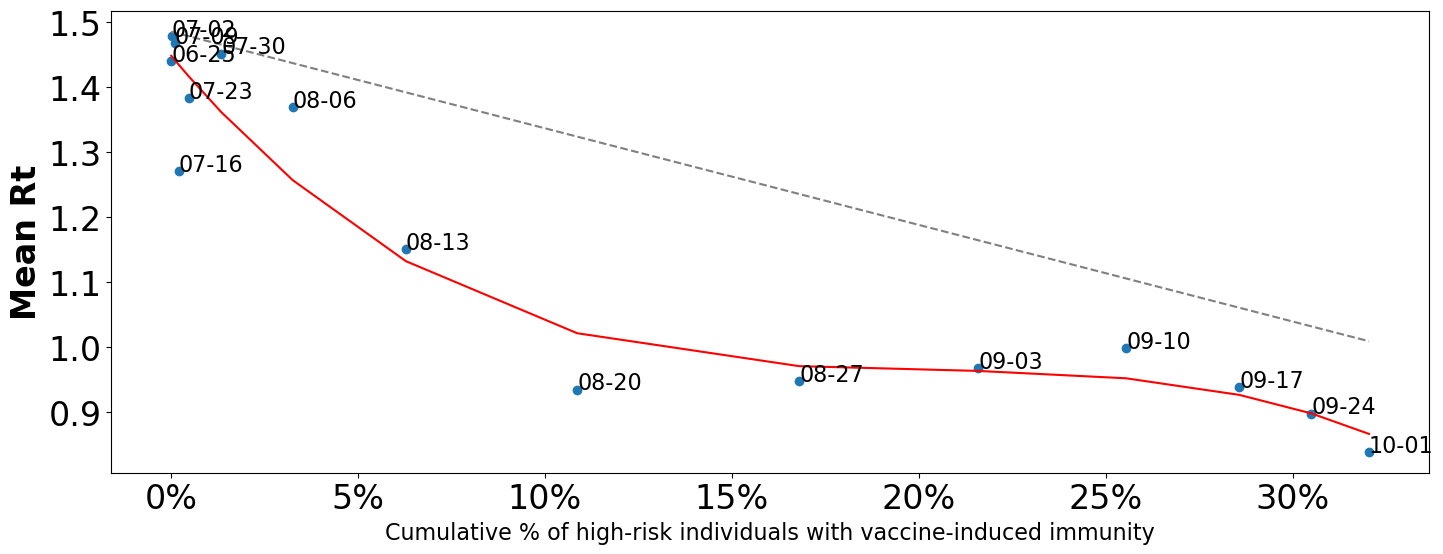

In [251]:
fig,ax1 = plt.subplots(figsize=(17,6),facecolor='w')
#ax1.axhline(y=1.0, color='k', linestyle='dashed', alpha = 0.6)

tck_s = splrep(combined_vac_df.cm_perc, combined_vac_df.mean_percent_x, s=len(combined_vac_df.cm_perc))
plt.plot(combined_vac_df.cm_perc, BSpline(*tck_s)(combined_vac_df.cm_perc), '-',color = "r", label=f's={len(combined_vac_df.cm_perc)}')

x = combined_vac_df.cm_perc
y = -(1.485519 * x*0.01) + 1.485519
plt.plot(x,y, color = "grey", linestyle = "dashed")
#ax1.text(.5, .65, 'y = -(1.486x)+ 1.486',
#        transform=ax1.transAxes, size = 18)


corr, _ = pearsonr(combined_vac_df.cm_perc, combined_vac_df.mean_percent_x)

r, p = sp.stats.pearsonr(combined_vac_df.cm_perc, combined_vac_df.mean_percent_x)
#ax1.text(.2, .75, 'r={:.2f}, p={:.2g}'.format(r, p),
#        transform=ax1.transAxes)


n = combined_vac_df.Date

ax1.scatter(x="cm_perc", y="mean_percent_x", data = combined_vac_df)


for i, txt in enumerate(n):
    ax1.annotate(str(txt)[5:10], (combined_vac_df.cm_perc[i], combined_vac_df.mean_percent_x[i]), size = 16)

#sns.regplot(x="cm_perc", y="mean_percent_x", data = combined_vac_df, scatter=True, ax=ax1, color='steelblue', line_kws={'linestyle': '--', 'linewidth': 1}, label='Pearson Correlation: {corr:.2f}')
#ax1.line()
vals = ax1.get_xticks()/100
ax1.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
plt.ylabel("Mean Rt", size = 24,  fontweight='bold')
plt.xlabel("Cumulative % of high-risk individuals with vaccine-induced immunity", size = 16)
plt.xticks(size = 24)
plt.yticks(size = 24)
#pyplot.phase_spectrum( combined_vac_df.mean_percent_x, color ='green')

plt.savefig("../figures/rt_vs_vaccine.png", pad_inches = 0)

plt.show()

## now we separate out Rt by contribution 

In [83]:
smoothed_intro_rt_no_intro['Contribution'] = "Local"
smoothed_intro_rt['Contribution'] = "Local + Intoductions"
smoothed_intro_rt_na = smoothed_intro_rt[smoothed_intro_rt.deme_x == "North America"]
smoothed_intro_rt_no_intro_na = smoothed_intro_rt_no_intro[smoothed_intro_rt_no_intro.deme_x == "North America"]


In [84]:
combined_rt_na = pd.concat([ smoothed_intro_rt_na, smoothed_intro_rt_no_intro_na], ignore_index=True)
combined_rt_all = pd.concat([ smoothed_intro_rt, smoothed_intro_rt_no_intro], ignore_index=True)

In [85]:
combined_rt_na = combined_rt_na[combined_rt_na.date > "2022-05-30"]
combined_rt_all = combined_rt_all[combined_rt_all.date > "2022-05-30"]

## plotting figure S6a

In [88]:
stream_graph_all =  alt.Chart(combined_rt_all, title = "").mark_area(interpolate='monotone', opacity = 0.8 ,color = "#f58518", clip = True).encode(
    alt.X('date:T', axis=alt.Axis(title="",tickCount = "month", grid=False,format="%B %Y")),
    alt.Y('mean_percent_x',axis=alt.Axis(title="Estimated Rt", grid=False),stack = False, scale=alt.Scale(domain=(0, 2.5))),
    #alt.Y2('upper_hpd_log_50' ), 
    alt.Color('Contribution:N',legend=alt.Legend(title= "Contribution",offset = -180, labelFontSize = 16, titleFontSize = 20)),
    alt.Row("deme_x:N",
        header=alt.Header(labelFontSize=20))
).properties(
    width=800,
    height=300
).transform_filter(datum.deme_x != "Central Europe")

stream_graph_all.configure_view(
    strokeWidth=0
).configure_title(
    anchor='start', fontSize= 35
).configure_axis(
    labelFontSize=20,
    titleFontSize=20
).configure_legend(
    labelFontSize = 30)


alt.Chart(...)